# DATA PROJECT - INFLATION AND ECOLOGICAL GOODS

### I explore the effect of inflation on the quantity sold of ecological goods in Denmark to answer the question: Do people buy less ecological goods when inflation is high?

I examine the potential connection between the inflation and the quantity sold of ecological goods in Denmark, considering goods of food as necessary goods.To conduct the analysis, I use data from Statistics Denmark for the growth in inflation in a period between 2005 to 2022. I use the API for Statistics Denmark to download the data from their website.

I calculate the growth in the quantity sold of ecological goods. I then examine the data by plotting the inflation between 2005 and 2022 in one plot and plotting the quantity sold of selected ecological goods in the same period in another plot. 
I then merge the datasets to compare the growth in the quantity sold of ecological goods to the growth in inflation.
The plots does not show any correlation between the growth in inflation and the growth in ecological goods sold.


Import and set magics. 
Install the API for downloading data from Statistics Denmark.

In [1]:
# Packages needed to run the notebook
import pandas as pd
import numpy as np

# Packages needed for the plots
import matplotlib.pyplot as plt
import ipywidgets as widgets
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import seaborn as sns
from ipywidgets import interact, Dropdown

# Autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# The DST API wrapper. Uncomment the first line to install the DST API, if not installed already
# %pip install git+https://github.com/alemartinello/dstapi
from dstapi import DstApi # install with `pip install git+https://github.com/alemartinello/dstapi`

Part of the project has been made with the help from openAI chatgpt.
Sections where chatgpt has been made the dominant part of the code has been marked.

# Read and clean data

I import data on inflation from Statistics Denmark using the API. I use the table PRIS9.

In [2]:
# Import table PRIS9 from Statistics Denmark
inf = DstApi('PRIS9') 

# Overview the data in the table
tabsum = inf.tablesummary(language='en')

# Display
#display(tabsum)

# The deafult in the _define_base_params-method is to select all avaiable data
params = inf._define_base_params(language='en')
#params

Table PRIS9: Consumer price index, annual rate of change by type and time
Last update: 2024-01-10T08:00:00


Data cleaning 

In [3]:
# Select the years from 2005 and to 2022
variables = params['variables'] 
variables[1]['values'] =['>2004<=2022']

# Load the data from Statistics Denmark using the API and the params dictionary specifications 
inf_api = inf.get_data(params=params)

# Delete the column TYPE and rename the column INDHOLD to Inflation
inf_api.drop(columns=['TYPE'], inplace=True)
inf_api.rename(columns={'INDHOLD' : 'Inflation'} , inplace=True)

# Transform both the Inflation and the TID column to numeric instead of strings
inf_api['Inflation'] = pd.to_numeric(inf_api['Inflation'])
inf_api['TID'] = pd.to_numeric(inf_api['TID'])

# Set the TID column to be the index
inf_api.set_index('TID', inplace=True)
inf_api.index = pd.to_numeric(inf_api.index)

# Display the first 10 rows in the cleaned dataset
inf_api.head(10)


,Inflation
TID,
2005,1.8
2006,1.9
2007,1.7
2008,3.4
2009,1.3
2010,2.3
2011,2.8
2012,2.4
2013,0.8


Import data on ecological goods from Statistics Denmark using the API. I use the table OEK3.

In [4]:
# Import the second data set containing the amount of ecological products sold in Denmark over time
eco = DstApi('OEKO3') 

# Overview the data in the table
tabsum = eco.tablesummary(language='en')

# Display
#display(tabsum)

# The default in the _define_base_params -method is to select all avaiable data
params_eco = eco._define_base_params(language='en')
#params_eco

Table OEKO3: Turnover of organic foods in retail shops by commodities, unit and time
Last update: 2024-04-26T08:00:00


Data cleaning

In [5]:
# Select the variables, and the time period and the quantity sold 
variables_eco = params_eco['variables'] 
variables_eco[0]['values'] = ['5000', '5130' , '5105' , '5070' , '5030']
variables_eco[1]['values'] = ['0010']
variables_eco[2]['values'] =['>2003<=2022']

# Load the data from Statistics Denmark using the API and the params_eco dictionary specifications 
eco_api = eco.get_data(params=params_eco)

# Change the column TID to the index column and delete the column MÆNGDE4
eco_api['TID'] = pd.to_numeric(eco_api['TID'])
eco_api.set_index('TID', inplace=True)
eco_api.drop(columns=['MÆNGDE4'], inplace=True)

# Display the first 10 rows of the cleaned dataset
eco_api.head(10)

,VARE,INDHOLD
TID,,
2004,"TURN OVER, TOTAL",154653
2004,"MEAT, SPREADS,OFFAL, TOTAL",2002
2004,"MILK, CHEESE, EGGS, TOTAL",109155
2004,"FRUITS, TOTAL",3658
2004,"VEGETABLES, TOTAL",18043
2005,"TURN OVER, TOTAL",168454
2005,"MEAT, SPREADS,OFFAL, TOTAL",2549
2005,"MILK, CHEESE, EGGS, TOTAL",116949
2005,"FRUITS, TOTAL",4819


## Examening the Data

I calculate the percentage change in the quantity sold of ecological goods in Denmark in the period between 2005 and 2022

In [6]:
# This section is made with help from chatgpt

# Create an empty DataFrame to store the results
percentage_changes = pd.DataFrame()

# Define the period
years = range(2004, 2023) 

# Loop through each year and create the variable current_year_values and next_year_values
for TID in years:
    if TID + 1 in eco_api.index:
        current_year_values = eco_api.loc[eco_api.index == TID, 'INDHOLD'].astype(float)
        next_year_values = eco_api.loc[eco_api.index == TID + 1, 'INDHOLD'].astype(float)
        
        # Calculate the percentage change for each variable
        change = (next_year_values.values - current_year_values.values) / current_year_values.values * 100
        
        # Create a new column in the results DataFrame for each year
        percentage_changes[f'{TID+1}'] = change

# Rename the index-column to the true variable names
Variables_names = ['Total_Turn_Over' , 'Total_Meat' , 'Total_Dairy' , 'Total_Fruits' , 'Total_Vegetables' ]
percentage_changes.index = Variables_names

# Transpose the dataframe so the years become the index column
percentage_changes_transposed = percentage_changes.T
percentage_changes_transposed = percentage_changes_transposed.rename_axis('TID')

# Transform index column to numeric values
percentage_changes_transposed.index = pd.to_numeric(percentage_changes_transposed.index)

# Display the results DataFrame
percentage_changes_transposed.head(18)

,Total_Turn_Over,Total_Meat,Total_Dairy,Total_Fruits,Total_Vegetables
TID,,,,,
2005,8.923849,27.322677,7.140305,31.738655,17.408413
2006,10.900899,16.869361,10.817536,15.521893,5.074585
2007,12.751516,11.782477,5.656636,58.200108,18.666607
2008,10.923903,20.660661,3.757367,9.810378,21.087302
2009,9.616562,-9.955202,10.037586,31.061938,3.901951
2010,4.256241,0.138198,-1.450712,15.416174,27.657078
2011,-0.995435,-0.469224,0.175895,-4.422722,-8.488320
2012,-8.870068,-2.689961,-10.214462,-9.512230,-6.671475
2013,2.977851,14.733542,5.630164,-2.173569,-7.846655


I plot the percentage change in the quantity sold of ecological goods in Denmark

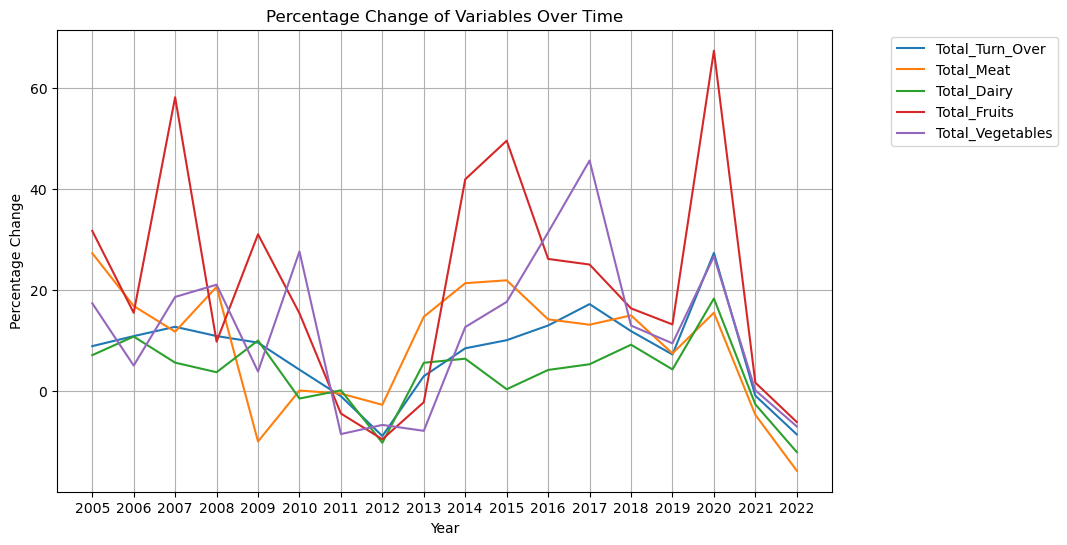

In [7]:

# Create a plot
plt.figure(figsize=(10, 6))

# Loop through each variable and plot the percentage change 
for variable in percentage_changes_transposed.columns:
    plt.plot(percentage_changes_transposed.index, percentage_changes_transposed[variable], label=variable)

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Percentage Change')
plt.title('Percentage Change of Variables Over Time')
plt.xticks(np.arange(2005, 2023, step=1))
plt.legend()
plt.grid(True)

plt.legend(frameon=True,loc='upper right',bbox_to_anchor=(1.3,1.0));

# Show plot
plt.show();

The plot shows huge flucturations in the growth of quantity of ecological goods sold over the period. Especially the growth in the amount sold of ecological fruits and vegetables are very volatile, while the amount of ecological dairy-products is rather constant.

I plot the percentage change in the inflation in Denmark

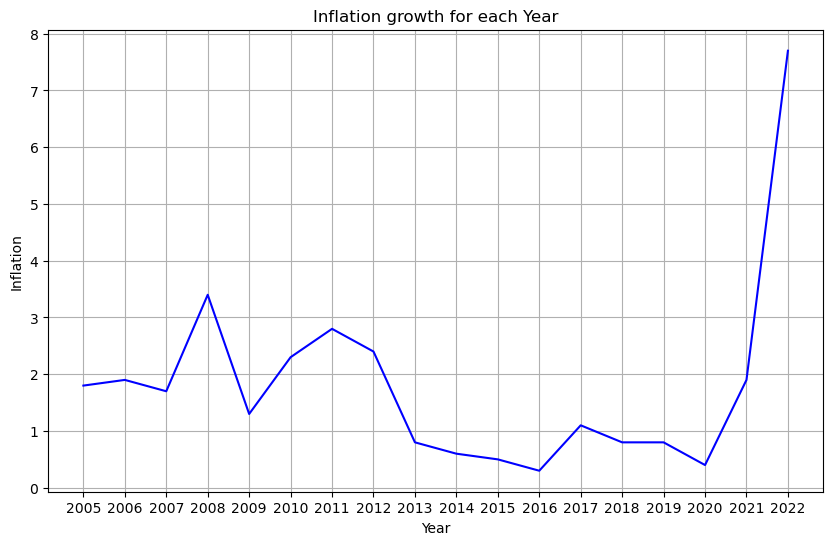

In [8]:
# Plotting
plt.figure(figsize=(10, 6))

# Plotting inflation growth for each year
plt.plot(inf_api.index, inf_api['Inflation'], color='blue', linestyle='-')

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Inflation')
plt.title('Inflation growth for each Year')
plt.xticks(inf_api.index[::1])

# Show plot
plt.grid(True)
plt.show();

The plot shows a stabil growth in inflation between 0 pct. and 3.5 pct. a year in the period between 2005 and 2021. In 2022 the growth in inflation exploded with 7.7 pct., which is a huge outlier compared to the rest of the period.

# Merge data sets

I merge the datasets `percentage_changes_transposed` and `inf_api`. I use the join-method, as this method merge the datasets by the index-column.

In [9]:
# Merge the two datasets by the index-column using the join-function 
dev = percentage_changes_transposed.join(inf_api) 
dev.head(10)

,Total_Turn_Over,Total_Meat,Total_Dairy,Total_Fruits,Total_Vegetables,Inflation
TID,,,,,,
2005,8.923849,27.322677,7.140305,31.738655,17.408413,1.8
2006,10.900899,16.869361,10.817536,15.521893,5.074585,1.9
2007,12.751516,11.782477,5.656636,58.200108,18.666607,1.7
2008,10.923903,20.660661,3.757367,9.810378,21.087302,3.4
2009,9.616562,-9.955202,10.037586,31.061938,3.901951,1.3
2010,4.256241,0.138198,-1.450712,15.416174,27.657078,2.3
2011,-0.995435,-0.469224,0.175895,-4.422722,-8.488320,2.8
2012,-8.870068,-2.689961,-10.214462,-9.512230,-6.671475,2.4
2013,2.977851,14.733542,5.630164,-2.173569,-7.846655,0.8


The join-method keeps all elements in the datasets and merge the datasets by their index-column. It is important that the index-column is the same for both datasets to have a succesful merge. The index-column will only appear once after the merge. 

# Analysis

**Interactive plot** :

In [10]:
def plot_interactive(ax: plt.Axes, x: list, y: list, title: str, xlabel: str, ylabel: str):

    # Create a line plot with a trend
    ax.scatter(x, y)
    sns.regplot(x = x, y = y, scatter = False, ax = ax)
   
    # Set the title and the labels for the axis
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

In [11]:
# Function to plot the selected dataset
def plot_dataset(dataset_name):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    if dataset_name == 'Total Turn Over':
        y = dev['Total_Turn_Over']
        ylabel = 'Change in total turn over in pct'
    elif dataset_name == 'Total Fruits':
        y = dev['Total_Fruits']
        ylabel = 'Change in total fruits in pct'
    elif dataset_name == 'Total Vegetables':
        y = dev['Total_Vegetables']
        ylabel = 'Change in total vegetables in pct'
    elif dataset_name == 'Total Dairy':
        y = dev['Total_Dairy']
        ylabel = 'Change in total dairy in pct'
    elif dataset_name == 'Total Meat':
        y = dev['Total_Meat']
        ylabel = 'Change in total meat in pct'
    else:
        return
    
    plot_interactive(ax=ax, x=dev['Inflation'], y=y, title=f'{dataset_name} and Inflation', xlabel='Inflation in pct', ylabel=ylabel)
    plt.show()

# Dropdown widget to select dataset
dropdown = Dropdown(options=['Total Turn Over', 'Total Fruits', 'Total Vegetables', 'Total Dairy', 'Total Meat'], description='Select Data')

# Interactive plot using the dropdown widget
interact(plot_dataset, dataset_name=dropdown);

interactive(children=(Dropdown(description='Select Data', options=('Total Turn Over', 'Total Fruits', 'Total V…

The interactive plot shows a weak tendency to have a lower quantity of goods sold, when the inflation is high. 
For most years the inflation has not been higher than 3.5 pct. and hence some of the effect is driven by the huge outlier in inflation of almost 8 pct. in 2022. 

I remove the outlier of 2022 to see if the negative correlation persist

In [12]:
# Remove the year 2022 from the merged dataset
merged = dev.loc[dev.index != 2022]
merged.head(17)

,Total_Turn_Over,Total_Meat,Total_Dairy,Total_Fruits,Total_Vegetables,Inflation
TID,,,,,,
2005,8.923849,27.322677,7.140305,31.738655,17.408413,1.8
2006,10.900899,16.869361,10.817536,15.521893,5.074585,1.9
2007,12.751516,11.782477,5.656636,58.200108,18.666607,1.7
2008,10.923903,20.660661,3.757367,9.810378,21.087302,3.4
2009,9.616562,-9.955202,10.037586,31.061938,3.901951,1.3
2010,4.256241,0.138198,-1.450712,15.416174,27.657078,2.3
2011,-0.995435,-0.469224,0.175895,-4.422722,-8.488320,2.8
2012,-8.870068,-2.689961,-10.214462,-9.512230,-6.671475,2.4
2013,2.977851,14.733542,5.630164,-2.173569,-7.846655,0.8


In [13]:
# Function to plot the selected dataset
def plot_dataset(dataset_name):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    if dataset_name == 'Total Turn Over':
        y = merged['Total_Turn_Over']
        ylabel = 'Change in total turn over in pct'
    elif dataset_name == 'Total Fruits':
        y = merged['Total_Fruits']
        ylabel = 'Change in total fruits in pct'
    elif dataset_name == 'Total Vegetables':
        y = merged['Total_Vegetables']
        ylabel = 'Change in total vegetables in pct'
    elif dataset_name == 'Total Dairy':
        y = merged['Total_Dairy']
        ylabel = 'Change in total dairy in pct'
    elif dataset_name == 'Total Meat':
        y = merged['Total_Meat']
        ylabel = 'Change in total meat in pct'
    else:
        return
    
    plot_interactive(ax=ax, x=merged['Inflation'], y=y, title=f'{dataset_name} and Inflation', xlabel='Inflation in pct', ylabel=ylabel)
    plt.show()

# Dropdown widget to select dataset
dropdown = Dropdown(options=['Total Turn Over', 'Total Fruits', 'Total Vegetables', 'Total Dairy', 'Total Meat'], description='Select Dataset')

# Interactive plot using the dropdown widget
interact(plot_dataset, dataset_name=dropdown);

interactive(children=(Dropdown(description='Select Dataset', options=('Total Turn Over', 'Total Fruits', 'Tota…

It is clear that the negative correlation weakens when the outlier is removed from the data set, but a weak negative correlation still persist. The negative correlation is most outspoken for the ecological fruits, but is also visible for the other ecological food products.

# Conclusion

The data display the development in the growth in inflation and the growth in the quantity of ecological goods sold in Denmark in the period between 2005 and 2022.

In the recent years the development in the amount of ecological goods sold have been very volatile, especially for ecological fruits and vegetables, while the quantity of ecological dairy product sold has been more stabil. 
The growth in inflation has been between 0-3.5 pct. a year for the period before 2022. In 2022 the inflation growth exploded at a high of 7 pct. 

The analysis display a weak negative correlation between high inflation and the amount of ecological goods bought. When inflation is high, there is a tendency to the quantity of ecological goods sold to be low. Treating goods of food as necessary goods, the analysis imply that when inflation is high constumers will tend to substitute away from ecological food products, presumably to buy more conventional food products. 
